<a href="https://colab.research.google.com/github/StetskoSergey/pida5_stetsko/blob/master/aml6%20dz_002_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [0]:
%matplotlib inline
import cv2
import numpy as np
from sklearn import datasets
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [0]:
train = np.loadtxt('./train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./test.csv', delimiter=',', skiprows=1)

In [0]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [0]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

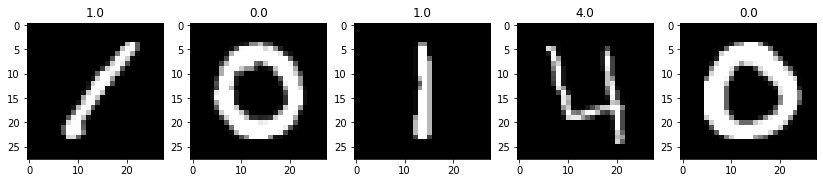

In [0]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [0]:
# Функия HOG
def applyHOG(d_set):
  list_hog_fd = []
  for i, feature in enumerate(d_set, 1):
    fd = hog(feature, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1))
    list_hog_fd.append(fd)
  return np.array(list_hog_fd, 'float64')

In [0]:
# Функция PCA
def applyPCA(d_set):
  pcaf = PCA(n_components=30)
  pcaf.fit(d_set.reshape(d_set.shape[0], 28*28))
  return pcaf.transform(d_set.reshape(d_set.shape[0], 28*28)), pcaf

In [0]:
def rf_(features):
  y_train, y_val, x_train, x_val = train_test_split(
    train_label, features, test_size=0.2,
    random_state=42)
  rf = RandomForestClassifier(random_state=0)
  rf.fit(x_train, y_train)
  return rf.score(x_val, y_val), rf

def rf_full(features):
  rf = RandomForestClassifier(random_state=0)
  rf.fit(features, train_label)
  return rf  

In [0]:
# формируем свойства
hog_features = applyHOG(train_img)
pca_features, pcaf = applyPCA(train_img) 

In [0]:
# Делаем обучение классификатора
hog_score, hog_rf = rf_(hog_features)
pca_score, pca_rf = rf_(pca_features)

In [0]:
print('Точность pca', pca_score)
print('Точность hog', hog_score)

Точность pca 0.9463095238095238
Точность hog 0.883452380952381


In [0]:
# Обучаем модели на полной выборке
hog_rf = rf_full(hog_features)
pca_rf = rf_full(pca_features)


## Предсказания на тестовых данных

In [0]:
test_HOG = applyHOG(test_img)
test_PCA = pcaf.transform(test_img.reshape(test_img.shape[0], 28*28))
pred_test_HOG = hog_rf.predict(test_HOG)
pred_test_PCA = pca_rf.predict(test_PCA)

## Визуализируем предсказания

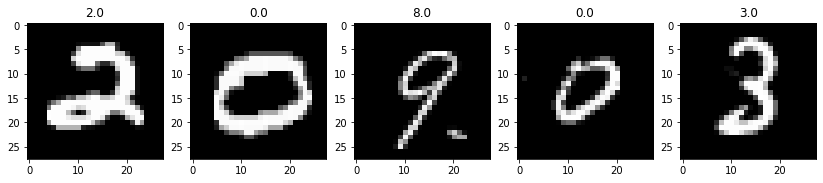

In [0]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test_HOG[i - 1]);

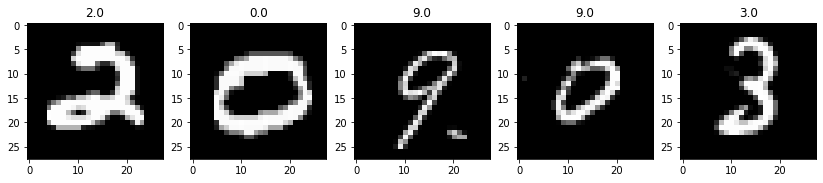

In [0]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test_PCA[i - 1]);

## Готовим файл для отправки

In [0]:
def prep_sub(f_name, pred):
  with open(f_name+'.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred, 1):
        dst.write('%s,%s\n' % (i, int(p)))
prep_sub('submit_HOG', pred_test_HOG)
prep_sub('submit_PCA', pred_test_PCA)       

In [0]:
# HOG submission scored 0.88757 
# PCA submission scored 0.94971 - лучше

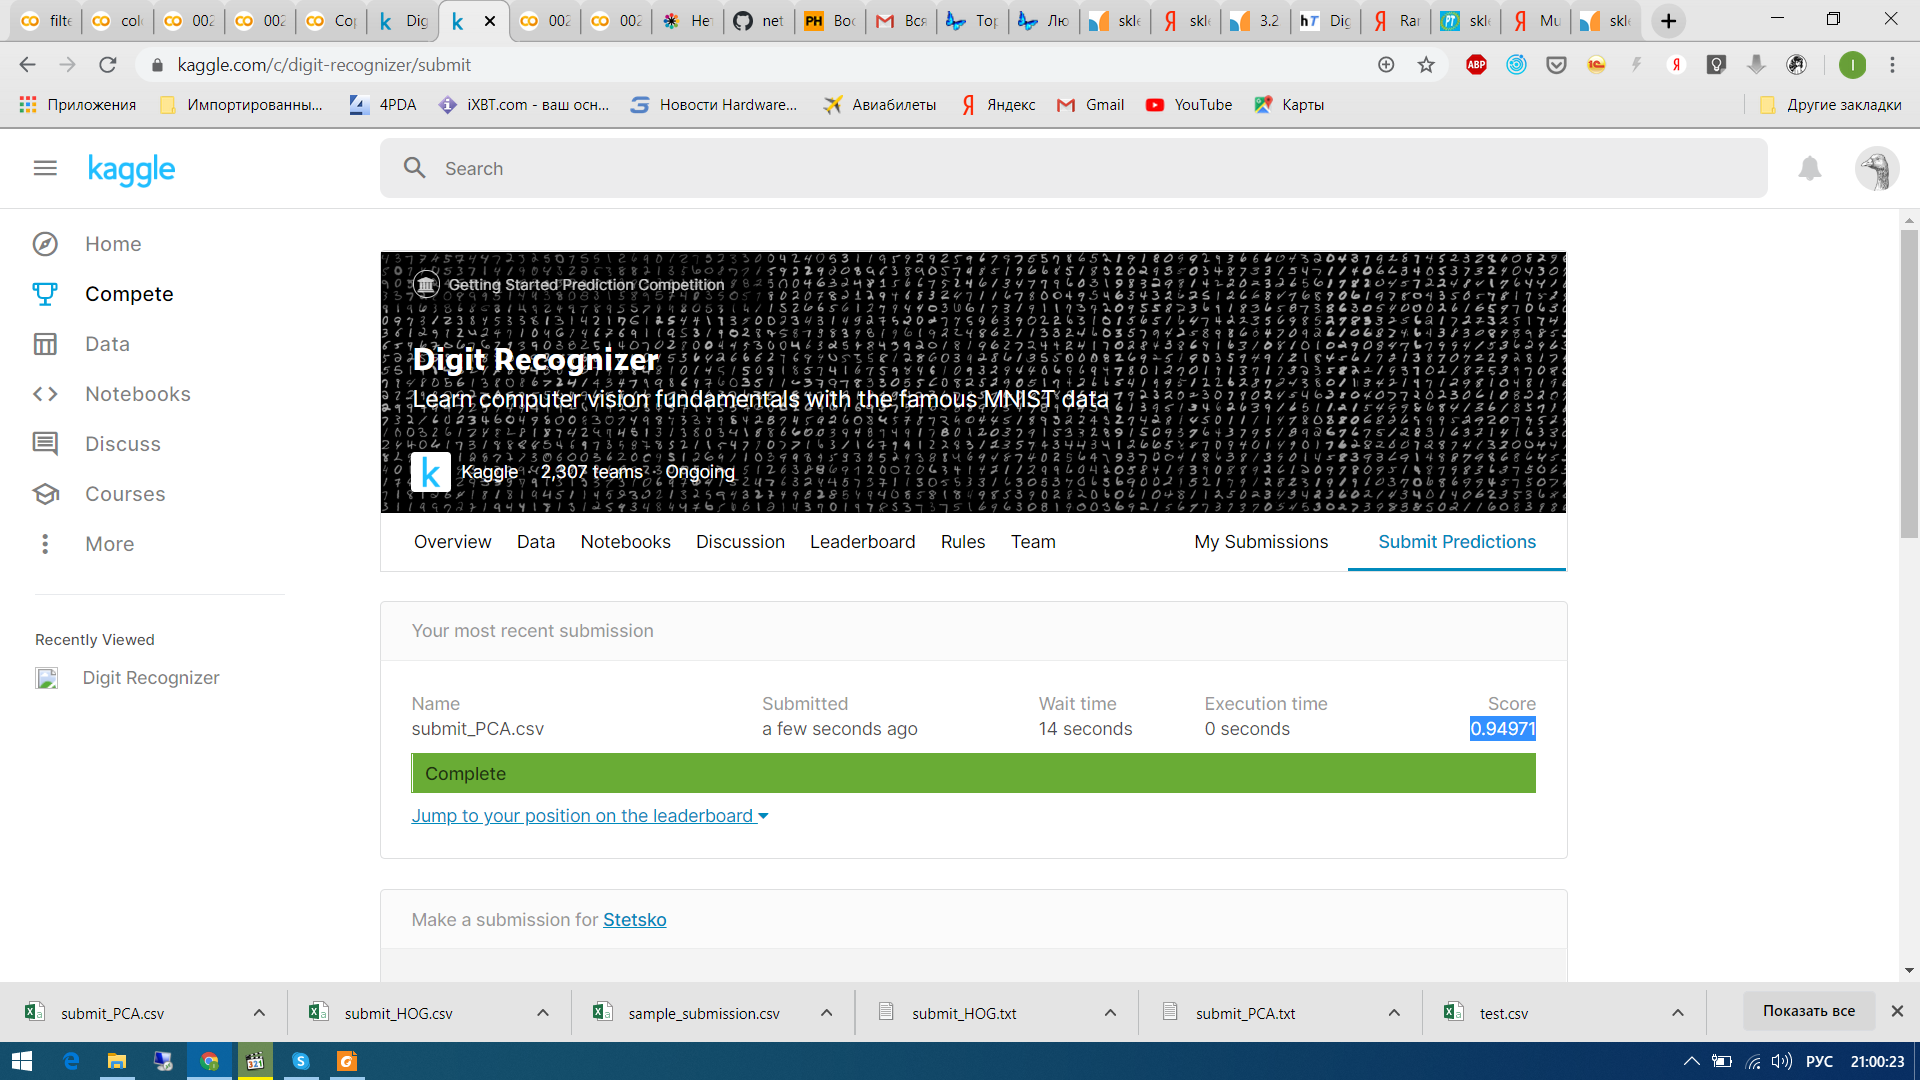